In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import get_data
import matplotlib.pyplot as plt
import population_activity as pop
import helper_functions as hf
import analysis
import plots
import decoding2 as decoding2
import statistics_test as st
from IPython.display import display, HTML

def print_large(text):
    display(HTML(f"<span style='font-size: 20px;'>{text}</span>"))
    
    

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
maps_reverse =  ['17', '15', '14'] + [str(i) for i in np.arange(12, -1, -1)]
datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
days1 = [str(i) for i in np.arange(0, 13)] +  ['14', '15', '17', '19']
days2 = ['19','17', '15', '14'] + [str(i) for i in np.arange(12, -1, -1)]

configs = [
    ('Context1', maps, '0', days1, False, False),  
    ('Context2', maps, '0', days1, False, False),
    ('Context2', maps_reverse, '19', days2, False, False),
    ('Context2', maps, '19', days1, True, False),
    ('Context1', None, '0', days1, False, True)
     
]

def run_analysis(datapath, context, sessions, ref_session, days, cross, is_drift):
    if not is_drift:
        res_align = analysis.loop_sessions_2datas(analysis.AK_align_2_sets2, datapath, ref_session, sessions, context, cross, 'dpca', 6)
    else:
        simu_drift = analysis.simulate_drift(
            datapath, 
            session=ref_session, 
            Context=context, 
            days=len(days),  
            drift_type='circular', 
            standardize='stand', 
            odd_even=True, 
            global_seed=0, 
            remove_day_inactive=True
        )
        res_align = analysis.loop_sessions_3(
            analysis.AK_align_2_sets_sim, 
            simu_drift['drift_data'][0], 
            simu_drift['drift_data'][1:], 
            simu_drift['pos'],
            'dpca',
            6
        )
    
    translation_scale = [r[8] for r in res_align]
    ref = [r[0][r[2]] for r in res_align]
    align_population = [r[1][r[2]] for r in res_align]
    align_population.insert(0, ref[0])
    
    pop_correlation = [pop.ManifoldAnalysis.population_correlation(res_align[day][1], res_align[0][0]) for day in range(len(res_align))]
    error = [[r[3][6], r[3][5]] for r in res_align]
    rotated_data2 = [r[4] for r in res_align]
    pos_data2 = [r[5] for r in res_align]
    data1 = res_align[0][6]
    pos_data1 = res_align[0][7]
    scores_test, scores_new_list, _, _, _, _ = decoding2.decode_neural_activity(
        data1, pos_data1, rotated_data2, pos_data2, 
        use_shuffled=False, shuffle_seed=0, model_type='gnb'
    )
    scores_test_shuff, scores_new_list_shuff, _, _, _, _ = decoding2.decode_neural_activity(
        data1, pos_data1, rotated_data2, pos_data2, 
        use_shuffled=True, shuffle_seed=0, model_type='gnb'
    )
     
    return {
        'ref': ref,
        'align_population': align_population,
        'days': days,
        'pop_correlation': pop_correlation,
        'translation_scale': translation_scale,
        'scores_test': scores_test,
        'scores_new_list': scores_new_list,
        'scores_test_shuff': scores_test_shuff,
        'scores_new_list_shuff': scores_new_list_shuff,
        'errors': error
    }

results = {}
for i, (context, sessions, ref_session, days, cross, is_drift) in enumerate(configs):
    config_name = f"config_{i+1}"
    results[config_name] = {}
    for datapath in datapaths:
        file_name = datapath.split('/')[-1].split('.')[0]
        results[config_name][file_name] = run_analysis(
            datapath, context, sessions, ref_session, days, cross, is_drift
        )

In [1]:
# conf = ['fam', 'nov forward', 'nov reverse', 'across env', 'sim drift']
# selected_datapath = '170'
# i=0
# for config_name, config_results in results.items():
#     selected_file = selected_datapath
#     file_results = config_results[selected_file]
#     print_large(conf[i])
#     plots.plot_arrays(file_results['align_population'], file_results['days'], remove_zero_rows=True)
#     plt.show()
#     i+=1

In [2]:
# def analyze_config(results, config):
#     num_days = len(results[config]['170']['scores_new_list']) + 1
#     matrix_shape = results[config]['170']['scores_new_list'][0]['cm_prob'].shape
#     sum_matrices = [np.zeros(matrix_shape) for _ in range(num_days)]
    
#     for animal in results[config]:
#         sum_matrices[0] += results[config][animal]['scores_test']['cm_prob']
#         for day in range(1, num_days):
#             sum_matrices[day] += results[config][animal]['scores_new_list'][day-1]['cm_prob']
    
#     num_animals = len(results[config])
#     avg_matrices = [sum_matrix / num_animals for sum_matrix in sum_matrices]
    
#     return avg_matrices

# def plot_config(avg_matrices, days, config):
#     plots.plot_arrays(avg_matrices, days, aspect=0.9, xlabel='predicted', ylabel='true', 
#                       show_colorbar=True, global_scale=True, scale_per_neuron=False, cmap='gist_heat', smooth_sigma=False) #, title=f'Configuration: {config}')

# configs = ['config_1', 'config_2', 'config_3', 'config_4', 'config_5']

# avg_matrices = [None] * len(configs)
# for i, config in enumerate(configs):
#     avg_matrices[i] = analyze_config(results, config)
#     days = days1 if i != 2 else days2
#     print_large(conf[i])
#     plot_config(avg_matrices[i], days, config)
#     plt.show()

C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\2067741529.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


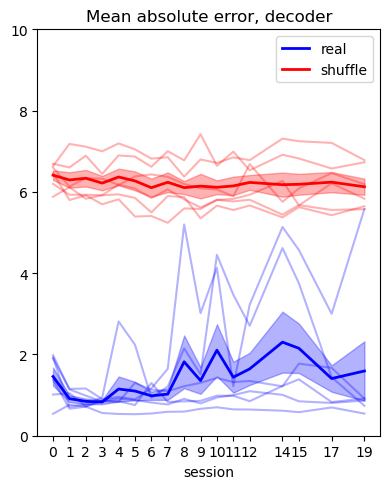

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,9.110021,16,80,0.569376,1.583971,0.092495,0.252182,0.061472,0.126509
1,condition,1174.639749,1,5,1174.639749,108.359206,0.000141,0.000141,0.894128,1.000000
2,time * condition,12.677064,16,80,0.792316,1.953409,0.026861,0.189488,0.083531,0.130843


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-15.0541,2.3427e-05,0.0004,***,-6.1458,Cohen's d,1.4561,6.4110,-4.9549,0.8062,6,True,0.7650
1,T2,C1,C2,t-test,-24.1273,2.2793e-06,3.8748e-05,***,-9.8499,Cohen's d,0.9123,6.2934,-5.3811,0.5463,6,True,0.9656
2,T3,C1,C2,t-test,-19.7512,6.1444e-06,0.0001,***,-8.0634,Cohen's d,0.8456,6.3361,-5.4906,0.6809,6,True,0.4632
3,T4,C1,C2,t-test,-25.2620,1.8142e-06,3.0842e-05,***,-10.3132,Cohen's d,0.8294,6.2161,-5.3867,0.5223,6,True,0.5169
4,T5,C1,C2,t-test,-11.4368,8.9504e-05,0.0015,**,-4.6691,Cohen's d,1.1491,6.3664,-5.2173,1.1174,6,True,0.4070
5,T6,C1,C2,t-test,-15.6699,1.9240e-05,0.0003,***,-6.3972,Cohen's d,1.0994,6.2705,-5.1712,0.8083,6,True,0.9716
6,T7,C1,C2,t-test,-17.2243,1.2079e-05,0.0002,***,-7.0318,Cohen's d,0.9821,6.1029,-5.1208,0.7282,6,True,0.5418
7,T8,C1,C2,t-test,-13.6487,3.7861e-05,0.0006,***,-5.5721,Cohen's d,1.0238,6.2370,-5.2133,0.9356,6,True,0.4462
8,T9,C1,C2,t-test,-5.1878,0.0035,0.0595,,-2.1179,Cohen's d,1.8184,6.1045,-4.2861,2.0238,6,True,0.0519
9,T10,C1,C2,t-test,-8.5404,0.0004,0.0062,**,-3.4866,Cohen's d,1.3570,6.1418,-4.7848,1.3723,6,True,0.6596


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\2067741529.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


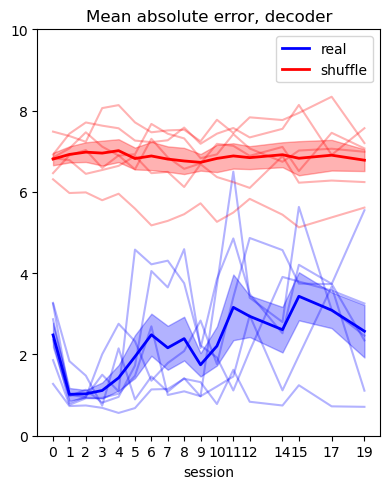

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,25.214373,16,80,1.575898,2.595680,0.002691,0.090452,0.115021,0.188566
1,condition,1097.185836,1,5,1097.185836,76.782266,0.000321,0.000321,0.849750,1.000000
2,time * condition,29.860303,16,80,1.866269,3.158956,0.000343,0.049484,0.133387,0.204696


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-11.4944,8.7353e-05,0.0015,**,-4.6926,Cohen's d,2.4797,6.8075,-4.3278,0.9223,6,True,0.8655
1,T2,C1,C2,t-test,-20.2504,5.4307e-06,9.2321e-05,***,-8.2672,Cohen's d,1.0189,6.9220,-5.9031,0.7140,6,True,0.2410
2,T3,C1,C2,t-test,-18.5978,8.2724e-06,0.0001,***,-7.5925,Cohen's d,1.0306,6.9781,-5.9475,0.7833,6,True,0.8368
3,T4,C1,C2,t-test,-19.2444,6.9872e-06,0.0001,***,-7.8565,Cohen's d,1.1132,6.9545,-5.8413,0.7435,6,True,0.5667
4,T5,C1,C2,t-test,-17.1751,1.2251e-05,0.0002,***,-7.0117,Cohen's d,1.4242,7.0144,-5.5902,0.7973,6,True,0.4883
5,T6,C1,C2,t-test,-7.7813,0.0006,0.0095,**,-3.1767,Cohen's d,1.9463,6.8208,-4.8745,1.5345,6,True,0.4004
6,T7,C1,C2,t-test,-4.9599,0.0042,0.0722,,-2.0249,Cohen's d,2.4851,6.8840,-4.3989,2.1725,6,True,0.0674
7,T8,C1,C2,wilcoxon,0.0000,0.0312,0.5312,,0.8987,r,2.1636,6.8070,-4.6434,2.1398,6,False,0.0291
8,T9,C1,C2,t-test,-4.8075,0.0049,0.0825,,-1.9626,Cohen's d,2.3894,6.7610,-4.3715,2.2274,6,True,0.1130
9,T10,C1,C2,t-test,-12.5502,5.7011e-05,0.0010,***,-5.1236,Cohen's d,1.7455,6.7268,-4.9813,0.9722,6,True,0.1474


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\2067741529.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


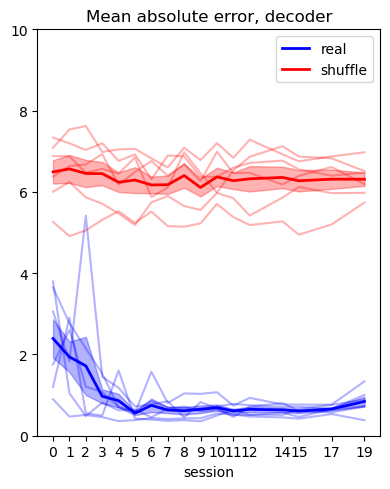

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,19.336390,16,80,1.208524,5.008169,5.210543e-07,0.017534,0.194835,0.166941
1,condition,1486.781199,1,5,1486.781199,343.979691,8.385689e-06,0.000008,0.948995,1.000000
2,time * condition,10.479264,16,80,0.654954,3.138546,3.700210e-04,0.058692,0.115937,0.182381


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-6.5628,0.0012,0.0209,*,-2.6792,Cohen's d,2.3922,6.4916,-4.0994,1.5300,6,True,0.7746
1,T2,C1,C2,t-test,-8.0888,0.0005,0.0080,**,-3.3022,Cohen's d,1.9389,6.5654,-4.6265,1.4010,6,True,0.2270
2,T3,C1,C2,t-test,-5.6574,0.0024,0.0408,*,-2.3096,Cohen's d,1.7191,6.4530,-4.7339,2.0496,6,True,0.4596
3,T4,C1,C2,t-test,-14.5774,2.7432e-05,0.0005,***,-5.9512,Cohen's d,0.9707,6.4494,-5.4787,0.9206,6,True,0.1871
4,T5,C1,C2,t-test,-36.9788,2.7236e-07,4.6301e-06,***,-15.0965,Cohen's d,0.8630,6.2382,-5.3752,0.3561,6,True,0.8102
5,T6,C1,C2,t-test,-17.0783,1.2597e-05,0.0002,***,-6.9722,Cohen's d,0.5558,6.2906,-5.7348,0.8225,6,True,0.2006
6,T7,C1,C2,t-test,-22.9994,2.8905e-06,4.9138e-05,***,-9.3894,Cohen's d,0.7470,6.1713,-5.4244,0.5777,6,True,0.5474
7,T8,C1,C2,t-test,-21.8996,3.6853e-06,6.2649e-05,***,-8.9405,Cohen's d,0.6320,6.1762,-5.5442,0.6201,6,True,0.4233
8,T9,C1,C2,t-test,-16.8505,1.3458e-05,0.0002,***,-6.8792,Cohen's d,0.6150,6.4017,-5.7867,0.8412,6,True,0.6924
9,T10,C1,C2,t-test,-20.7691,4.7917e-06,8.1459e-05,***,-8.4790,Cohen's d,0.6517,6.1083,-5.4567,0.6436,6,True,0.9907


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\2067741529.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


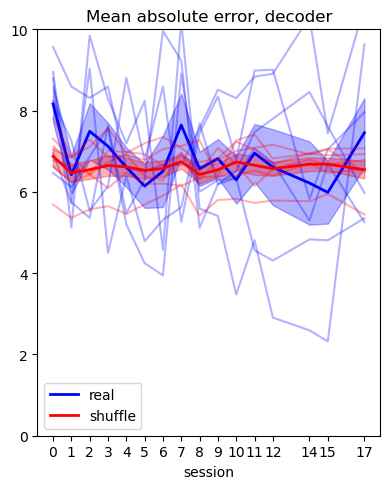

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,19.961960,15,75,1.330797,0.892166,0.575441,0.471079,0.062338,0.210000
1,condition,1.884773,1,5,1.884773,0.139904,0.723713,0.723713,0.006238,1.000000
2,time * condition,15.074100,15,75,1.004940,0.763092,0.712799,0.530970,0.047803,0.197614


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,1.7558,0.1395,1.0000,,0.7168,Cohen's d,8.1637,6.8755,1.2882,1.7971,6,True,0.5451
1,T2,C1,C2,t-test,-0.0754,0.9428,1.0000,,-0.0308,Cohen's d,6.4259,6.4692,-0.0433,1.4072,6,True,0.8157
2,T3,C1,C2,t-test,1.6608,0.1576,1.0000,,0.6780,Cohen's d,7.4910,6.5466,0.9444,1.3929,6,True,0.7404
3,T4,C1,C2,t-test,0.6547,0.5416,1.0000,,0.2673,Cohen's d,7.1232,6.6511,0.4721,1.7663,6,True,0.7713
4,T5,C1,C2,t-test,-0.0171,0.9870,1.0000,,-0.0070,Cohen's d,6.6072,6.6155,-0.0083,1.1875,6,True,0.6621
5,T6,C1,C2,t-test,-0.6116,0.5676,1.0000,,-0.2497,Cohen's d,6.1432,6.5302,-0.3870,1.5500,6,True,0.0872
6,T7,C1,C2,t-test,-0.0560,0.9575,1.0000,,-0.0229,Cohen's d,6.5086,6.5733,-0.0647,2.8296,6,True,0.3608
7,T8,C1,C2,t-test,1.0258,0.3520,1.0000,,0.4188,Cohen's d,7.6454,6.7420,0.9035,2.1575,6,True,0.2148
8,T9,C1,C2,t-test,0.3882,0.7139,1.0000,,0.1585,Cohen's d,6.5681,6.4276,0.1405,0.8866,6,True,0.7354
9,T10,C1,C2,t-test,0.5314,0.6179,1.0000,,0.2169,Cohen's d,6.8208,6.5441,0.2767,1.2756,6,True,0.9711


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\2067741529.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


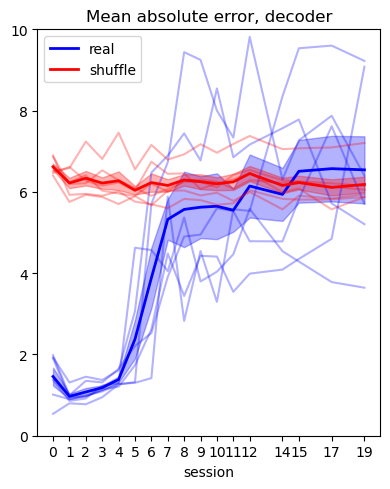

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,235.264116,16,80,14.704007,12.734281,6.725951e-16,0.000421,0.484683,0.167122
1,condition,209.771774,1,5,209.771774,38.195608,1.616443e-03,0.001616,0.456119,1.000000
2,time * condition,249.492624,16,80,15.593289,14.614169,1.534258e-17,0.000127,0.499358,0.181386


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-24.5802,2.0783e-06,3.5331e-05,***,-10.0348,Cohen's d,1.4561,6.6193,-5.1632,0.5145,6,True,0.9831
1,T2,C1,C2,t-test,-29.0637,9.0377e-07,1.5364e-05,***,-11.8652,Cohen's d,0.9676,6.2193,-5.2517,0.4426,6,True,0.3958
2,T3,C1,C2,t-test,-21.0523,4.4809e-06,7.6176e-05,***,-8.5946,Cohen's d,1.0761,6.3361,-5.2600,0.6120,6,True,0.6291
3,T4,C1,C2,t-test,-29.6609,8.1679e-07,1.3885e-05,***,-12.1090,Cohen's d,1.1819,6.2172,-5.0353,0.4158,6,True,0.6202
4,T5,C1,C2,t-test,-16.9871,1.2933e-05,0.0002,***,-6.9350,Cohen's d,1.3821,6.2750,-4.8928,0.7055,6,True,0.2116
5,T6,C1,C2,t-test,-6.3903,0.0014,0.0236,*,-2.6088,Cohen's d,2.3765,6.0403,-3.6638,1.4044,6,True,0.7341
6,T7,C1,C2,t-test,-2.6540,0.0452,0.7685,,-1.0835,Cohen's d,3.8845,6.2287,-2.3442,2.1636,6,True,0.9192
7,T8,C1,C2,t-test,-1.7299,0.1442,1.0000,,-0.7062,Cohen's d,5.3242,6.1582,-0.8340,1.1809,6,True,0.5180
8,T9,C1,C2,t-test,-0.7049,0.5123,1.0000,,-0.2878,Cohen's d,5.5688,6.2944,-0.7257,2.5216,6,True,0.9477
9,T10,C1,C2,t-test,-0.7019,0.5141,1.0000,,-0.2865,Cohen's d,5.6230,6.2505,-0.6275,2.1899,6,True,0.3154


In [9]:

def analyze_mae_config(results, config):
    animals = list(results[config].keys())
    num_animals = len(animals)
    
    if config == 'config_4':
        num_days = len(results[config][animals[0]]['scores_new_list'])
        mae_array = np.zeros((num_days, num_animals))  # Now correctly starting at day 1
        mae_array_shuff = np.zeros((num_days, num_animals))
    else:
        num_days = len(results[config][animals[0]]['scores_new_list']) + 1
        mae_array = np.zeros((num_days, num_animals))
        mae_array_shuff = np.zeros((num_days, num_animals))
    
    for i, animal in enumerate(animals):
        if config != 'config_4':
            mae_array[0, i] = results[config][animal]['scores_test']['mae']
            mae_array_shuff[0, i] = results[config][animal]['scores_test_shuff']['mae']
            
            for day in range(1, num_days):
                mae_array[day, i] = results[config][animal]['scores_new_list'][day-1]['mae']
                mae_array_shuff[day, i] = results[config][animal]['scores_new_list_shuff'][day-1]['mae']
        else:
            for day in range(num_days):
                mae_array[day-1, i] = results[config][animal]['scores_new_list'][day]['mae']
                mae_array_shuff[day-1, i] = results[config][animal]['scores_new_list_shuff'][day]['mae']
    
    return mae_array, mae_array_shuff



def plot_mae_configs_individual(results, configs, days1, days2):
    for i, config in enumerate(configs):
        mae_array, mae_array_shuff = analyze_mae_config(results, config)
        
        print_large('\n' + '=' * 50)
        print_large(titles[i])  
        print_large('\n' + '=' * 50)

        fig, ax = plt.subplots(figsize=(4, 5))


        days = days1[:mae_array.shape[0]]  

        mae_array = mae_array[::-1] if i == 2 else mae_array
        mae_array_shuff = mae_array_shuff[::-1] if i == 2 else mae_array_shuff

        plots.plot_average_geometry(
            [mae_array.T, mae_array_shuff.T],
            days,
            ax=ax,
            colors=['b', 'r'],
            ylim=[0, 10],
            labels=['real', 'shuffle']
        )

        plt.title(f'Mean absolute error, decoder')
        plt.tight_layout()
        plt.show()

        stat1 = st.repeated_measures_anova_general([mae_array.T, mae_array_shuff.T])
        display(stat1[0])
        display(stat1[1])

configs = ['config_1', 'config_2', 'config_3', 'config_4', 'config_5']
titles = ['fam aligned to fam d0', 'nov aligned to nov d0', 'nov aligned to nov d19', 'nov aligned to fam d19', 'sim fam aligned to sim fam d0']
plot_mae_configs_individual(results, configs, days1, days2)



C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\1782534822.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


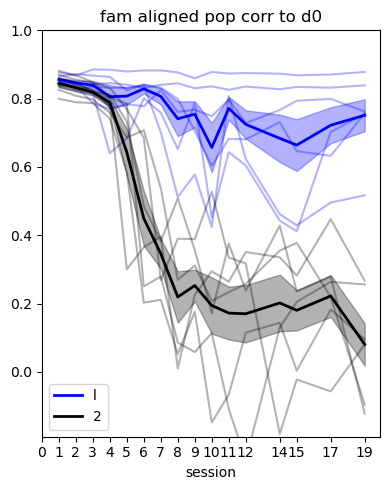

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,5.101126,15,75,0.340075,21.132570,5.133256e-21,0.000003,0.612746,0.232252
1,condition,6.405273,1,5,6.405273,67.875666,4.293357e-04,0.000429,0.665194,1.000000
2,time * condition,2.464407,15,75,0.164294,11.739883,3.769764e-14,0.000099,0.433241,0.239993


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,1.3905,0.2231,1.0000,,0.5677,Cohen's d,0.8558,0.8446,0.0111,0.0196,6,True,0.1826
1,T2,C1,C2,t-test,1.4621,0.2036,1.0000,,0.5969,Cohen's d,0.8464,0.8323,0.0141,0.0236,6,True,0.8744
2,T3,C1,C2,t-test,1.9370,0.1105,1.0000,,0.7908,Cohen's d,0.8389,0.8188,0.0200,0.0253,6,True,0.2012
3,T4,C1,C2,t-test,0.6120,0.5673,1.0000,,0.2498,Cohen's d,0.8057,0.7885,0.0173,0.0691,6,True,0.4614
4,T5,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.8074,0.6430,0.1644,0.1597,6,False,0.0032
5,T6,C1,C2,t-test,4.3471,0.0074,0.1181,,1.7747,Cohen's d,0.8288,0.4492,0.3796,0.2139,6,True,0.4342
6,T7,C1,C2,t-test,8.6756,0.0003,0.0054,**,3.5418,Cohen's d,0.8067,0.3459,0.4608,0.1301,6,True,0.2634
7,T8,C1,C2,t-test,4.4372,0.0068,0.1085,,1.8115,Cohen's d,0.7410,0.2192,0.5219,0.2881,6,True,0.2674
8,T9,C1,C2,t-test,5.9056,0.0020,0.0317,*,2.4109,Cohen's d,0.7545,0.2526,0.5019,0.2082,6,True,0.8710
9,T10,C1,C2,t-test,4.4037,0.0070,0.1120,,1.7978,Cohen's d,0.6569,0.1944,0.4626,0.2573,6,True,0.7478


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.374739,15,0.024983,3.711189,0.000076,0.255112,0.127816
1,Error,0.504877,75,0.006732,NaN,NaN,NaN,NaN


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\1782534822.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


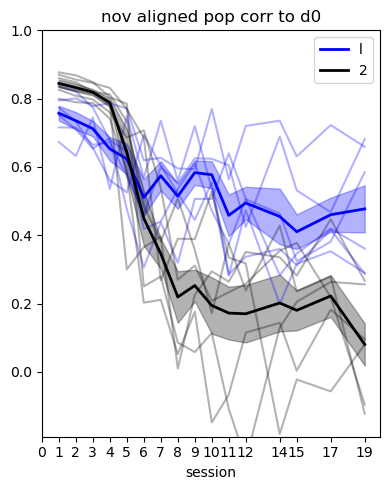

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,6.601546,15,75,0.440103,22.520546,7.942781e-22,0.000010,0.658067,0.195604
1,condition,1.249089,1,5,1.249089,12.707613,1.613273e-02,0.016133,0.266941,1.000000
2,time * condition,1.644534,15,75,0.109636,7.373118,1.145233e-09,0.001445,0.324065,0.236272


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-4.5813,0.0059,0.0951,,-1.8703,Cohen's d,0.7573,0.8446,-0.0874,0.0467,6,True,0.9777
1,T2,C1,C2,t-test,-4.6237,0.0057,0.0915,,-1.8876,Cohen's d,0.7353,0.8323,-0.0970,0.0514,6,True,0.9848
2,T3,C1,C2,t-test,-4.4310,0.0068,0.1091,,-1.8089,Cohen's d,0.7121,0.8188,-0.1068,0.0590,6,True,0.4020
3,T4,C1,C2,t-test,-3.4365,0.0185,0.2961,,-1.4029,Cohen's d,0.6528,0.7885,-0.1356,0.0967,6,True,0.7976
4,T5,C1,C2,t-test,-0.2698,0.7981,1.0000,,-0.1102,Cohen's d,0.6236,0.6430,-0.0194,0.1761,6,True,0.8546
5,T6,C1,C2,t-test,0.8486,0.4349,1.0000,,0.3464,Cohen's d,0.5107,0.4492,0.0614,0.1774,6,True,0.5808
6,T7,C1,C2,t-test,5.2716,0.0033,0.0523,,2.1521,Cohen's d,0.5740,0.3459,0.2282,0.1060,6,True,0.4755
7,T8,C1,C2,t-test,3.5566,0.0163,0.2604,,1.4520,Cohen's d,0.5143,0.2192,0.2951,0.2033,6,True,0.6239
8,T9,C1,C2,t-test,4.9465,0.0043,0.0688,,2.0194,Cohen's d,0.5834,0.2526,0.3307,0.1638,6,True,0.7784
9,T10,C1,C2,t-test,3.9085,0.0113,0.1810,,1.5957,Cohen's d,0.5771,0.1944,0.3827,0.2399,6,True,0.2819


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1.055285,15,0.070352,6.362892,1.901216e-08,0.447964,0.217173
1,Error,0.829249,75,0.011057,NaN,NaN,NaN,NaN


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\1782534822.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


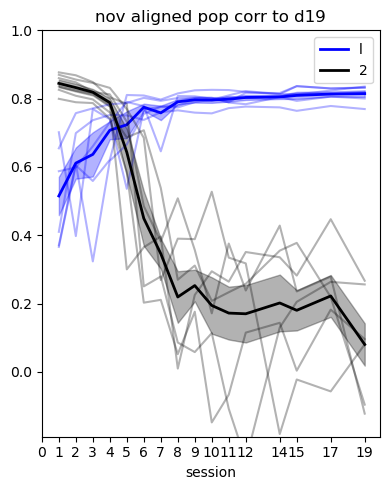

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.922254,15,75,0.128150,7.492656,8.312136e-10,1.545800e-03,0.426023,0.228651
1,condition,5.755462,1,5,5.755462,118.029121,1.147344e-04,1.147344e-04,0.689665,1.000000
2,time * condition,5.966338,15,75,0.397756,33.735861,3.185757e-27,1.457685e-07,0.697314,0.225216


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-5.6325,0.0024,0.0391,*,-2.2995,Cohen's d,0.5150,0.8446,-0.3296,0.1434,6,True,0.7926
1,T2,C1,C2,t-test,-4.4633,0.0066,0.1059,,-1.8221,Cohen's d,0.6112,0.8323,-0.2211,0.1213,6,True,0.4919
2,T3,C1,C2,t-test,-2.6256,0.0468,0.7485,,-1.0719,Cohen's d,0.6368,0.8188,-0.1821,0.1699,6,True,0.1540
3,T4,C1,C2,t-test,-2.4053,0.0612,0.9795,,-0.9820,Cohen's d,0.7075,0.7885,-0.0810,0.0825,6,True,0.7355
4,T5,C1,C2,t-test,1.9814,0.1044,1.0000,,0.8089,Cohen's d,0.7236,0.6430,0.0806,0.0996,6,True,0.3983
5,T6,C1,C2,t-test,3.8042,0.0126,0.2012,,1.5531,Cohen's d,0.7750,0.4492,0.3258,0.2098,6,True,0.4871
6,T7,C1,C2,t-test,7.2813,0.0008,0.0122,*,2.9726,Cohen's d,0.7583,0.3459,0.4124,0.1387,6,True,0.1651
7,T8,C1,C2,t-test,7.3722,0.0007,0.0115,*,3.0097,Cohen's d,0.7907,0.2192,0.5715,0.1899,6,True,0.3652
8,T9,C1,C2,t-test,11.4694,8.8279e-05,0.0014,**,4.6824,Cohen's d,0.7967,0.2526,0.5440,0.1162,6,True,0.2908
9,T10,C1,C2,t-test,7.3160,0.0007,0.0120,*,2.9867,Cohen's d,0.7960,0.1944,0.6016,0.2014,6,True,0.9672


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.697797,15,0.046520,8.399392,7.899525e-11,0.602636,0.162003
1,Error,0.415386,75,0.005538,NaN,NaN,NaN,NaN


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\1782534822.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


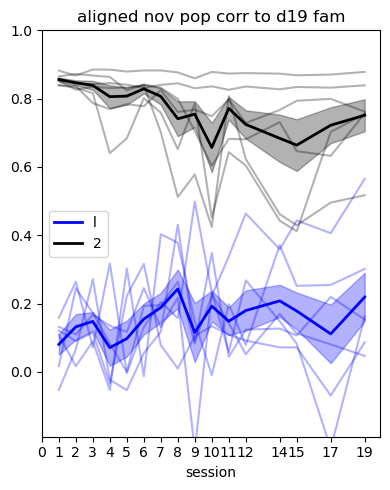

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.145957,15,75,0.009730,0.627604,0.843170,0.583291,0.049191,0.166440
1,condition,17.988041,1,5,17.988041,205.050838,0.000030,0.000030,0.864425,1.000000
2,time * condition,0.458815,15,75,0.030588,2.589282,0.003553,0.078023,0.139882,0.235419


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-26.8371,1.3433e-06,2.1494e-05,***,-10.9562,Cohen's d,0.0806,0.8558,-0.7752,0.0708,6,True,0.6358
1,T2,C1,C2,t-test,-15.7876,1.8545e-05,0.0003,***,-6.4453,Cohen's d,0.1318,0.8464,-0.7146,0.1109,6,True,0.0874
2,T3,C1,C2,t-test,-17.1656,1.2284e-05,0.0002,***,-7.0078,Cohen's d,0.1477,0.8389,-0.6911,0.0986,6,True,0.1370
3,T4,C1,C2,t-test,-10.5894,0.0001,0.0021,**,-4.3231,Cohen's d,0.0707,0.8057,-0.7350,0.1700,6,True,0.4166
4,T5,C1,C2,t-test,-15.2730,2.1824e-05,0.0003,***,-6.2352,Cohen's d,0.0973,0.8074,-0.7101,0.1139,6,True,0.4954
5,T6,C1,C2,t-test,-15.8351,1.8273e-05,0.0003,***,-6.4647,Cohen's d,0.1545,0.8288,-0.6743,0.1043,6,True,0.4526
6,T7,C1,C2,t-test,-10.7170,0.0001,0.0020,**,-4.3752,Cohen's d,0.1881,0.8067,-0.6186,0.1414,6,True,0.7022
7,T8,C1,C2,t-test,-6.0287,0.0018,0.0289,*,-2.4612,Cohen's d,0.2428,0.7410,-0.4982,0.2024,6,True,0.1411
8,T9,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.1151,0.7545,-0.6393,0.2906,6,False,0.0389
9,T10,C1,C2,t-test,-3.8324,0.0122,0.1955,,-1.5646,Cohen's d,0.1925,0.6569,-0.4644,0.2968,6,True,0.7186


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.230034,15,0.015336,0.744964,0.731559,0.11754,0.205425
1,Error,1.543926,75,0.020586,NaN,NaN,NaN,NaN


C:\Users\Ole\AppData\Local\Temp\ipykernel_19972\1782534822.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


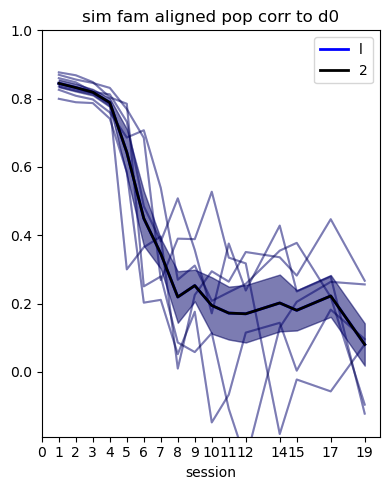

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\parametric.py:748: RuntimeWarning: invalid value encountered in scalar divide
  f_b = ms_b / ms_bs
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\parametric.py:749: RuntimeWarning: invalid value encountered in scalar divide
  f_ab = ms_ab / ms_abs
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\distribution.py:743: RuntimeWarning: invalid value encountered in scalar divide
  eps = np.min([num / den, 1])
c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\Ole\Documents\script\remapping\remapping\statistics_test.py:247: RuntimeWarning: invalid value encountered in scalar divide
  effect_size = np.mean(differences) / np.std(differences, ddof=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,14.38159,15,75,0.958773,20.525829,1.195594e-20,0.000005,0.771502,0.222599
1,condition,0.00000,1,5,0.000000,NaN,NaN,NaN,0.000000,1.000000
2,time * condition,0.00000,15,75,0.000000,NaN,NaN,NaN,0.000000,NaN


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.8446,0.8446,0.0,0.0,6,True,1.0000
1,T2,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.8323,0.8323,0.0,0.0,6,True,1.0000
2,T3,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.8188,0.8188,0.0,0.0,6,True,1.0000
3,T4,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.7885,0.7885,0.0,0.0,6,True,1.0000
4,T5,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.6430,0.6430,0.0,0.0,6,True,1.0000
5,T6,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.4492,0.4492,0.0,0.0,6,True,1.0000
6,T7,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.3459,0.3459,0.0,0.0,6,True,1.0000
7,T8,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.2192,0.2192,0.0,0.0,6,True,1.0000
8,T9,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.2526,0.2526,0.0,0.0,6,True,1.0000
9,T10,C1,C2,t-test,NaN,nan,nan,,NaN,Cohen's d,0.1944,0.1944,0.0,0.0,6,True,1.0000


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,7.190795,15,0.479386,20.525829,1.195594e-20,0.771502,0.222599
1,Error,1.751645,75,0.023355,NaN,NaN,NaN,NaN


In [10]:
def create_pop_correlation_arrays(results, datapaths):
    pop_correlation_arrays = {}
    for config_name, config_results in results.items():
        pop_correlation_arrays[config_name] = np.column_stack([
            config_results[file_name]['pop_correlation']
            for file_name in [path.split('/')[-1].split('.')[0] for path in datapaths]
        ])
    return pop_correlation_arrays

def plot_pop_correlations_individual(pop_correlation_arrays, maps, maps_reverse):
    plot_configs = [
        {
            'config': 'config_1',
            'title': 'fam aligned pop corr to d0',
            'maps': maps
        },
        {
            'config': 'config_2',
            'title': 'nov aligned pop corr to d0',
            'maps': maps
        },
        {
            'config': 'config_3',
            'title': 'nov aligned pop corr to d19',
            'maps': maps
        },
        {
            'config': 'config_4',
            'title': 'aligned nov pop corr to d19 fam',
            'maps': maps
        },
        {
            'config': 'config_5',
            'title': 'sim fam aligned pop corr to d0',
            'maps': maps
        }
    ]

    i=0
    for config in plot_configs:
        print_large('\n' + '='*50)
        print_large(config['title'])
        print_large('\n' + '='*50)
        fig,ax=plt.subplots(figsize=(4, 5))
        
        if config['config'] == 'config_3':
            pop_correlation_arrays[config['config']] = pop_correlation_arrays[config['config']][::-1]


        if config['config'] == 'config_4':
            config2 = 'config_1'
        else:
            config2 = 'config_5'


        plots.plot_average_geometry(
            [pop_correlation_arrays[config['config']].T, pop_correlation_arrays[config2].T],
            config['maps'],
            colors=['b', 'k'],
            ax=ax,
            title=config['title'],
            ylim=[-0.19, 1],
            labels=['l', '2']
        )
        plt.tight_layout()
        plt.show()

        print_large('\nTWO-WAY REPEATED ANOVA')
        anova=st.repeated_measures_anova_general([pop_correlation_arrays[config['config']].T,pop_correlation_arrays[config2].T])
        display(anova[0])
        display(anova[1])
        display(st.repeated_measures_anova_single_condition(pop_correlation_arrays[config['config']].T))
        i+=1
        

pop_correlation_arrays = create_pop_correlation_arrays(results, datapaths)
plot_pop_correlations_individual(pop_correlation_arrays, maps, maps_reverse)


In [11]:
all_before_correlations = []

for datapath in datapaths:
    hist_sorts = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference='0', maps = maps, transients = False, hist='hist')

    manifold_reference = hist_sorts[0] 
    manifold_before_rotation = [hist_sorts[day] for day in range(1,len(hist_sorts))]
    before_correlation = [pop.ManifoldAnalysis.population_correlation(manifold_before_rotation[day], manifold_reference) for day in range(len(manifold_before_rotation))]
    
    all_before_correlations.append(before_correlation)
all_before_correlations = np.vstack(all_before_correlations)




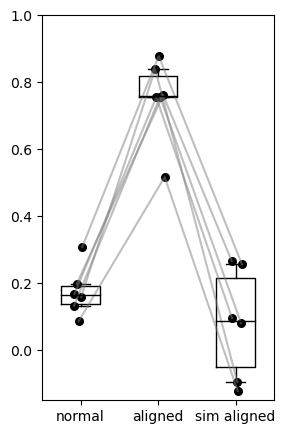

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1.583683,2,0.791842,114.082539,1.304997e-07,0.865923,0.750033
1,Error,0.069410,10,0.006941,NaN,NaN,NaN,NaN


,Timepoint 1,Timepoint 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Diff,SD Diff,Normal Dist.,Normality p-value
0,T1,T2,t-test,-16.9547,1.3056e-05,3.9167e-05,***,-6.9217,Cohen's d,-0.5765,0.0833,True,0.5351
1,T1,T3,t-test,1.9690,0.1061,0.3182,,0.8038,Cohen's d,0.0947,0.1179,True,0.5621
2,T2,T3,t-test,11.3955,9.1089e-05,0.0003,***,4.6522,Cohen's d,0.6712,0.1443,True,0.1982


In [12]:
align_last=pop_correlation_arrays['config_1'][-1]
sim_last=pop_correlation_arrays['config_5'][-1]
normal_last=all_before_correlations[:,-1].T
print_large('\n' + '='*50)
print_large('Comparing normal, aligned and sim aligned pop corr to d0, last day')
print_large('='*50)
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.vstack([[normal_last],[align_last],[sim_last]]).T, ['normal','aligned', 'sim aligned'],ax, '',ylim=[-0.15,1])

plt.show()
display(st.repeated_measures_anova_single_condition(np.vstack([normal_last,align_last,sim_last]).T))
display(st.post_hoc_timepoints(np.vstack([normal_last,align_last,sim_last])))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Ole\Documents\script\remapping\remapping\plots.py:546: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


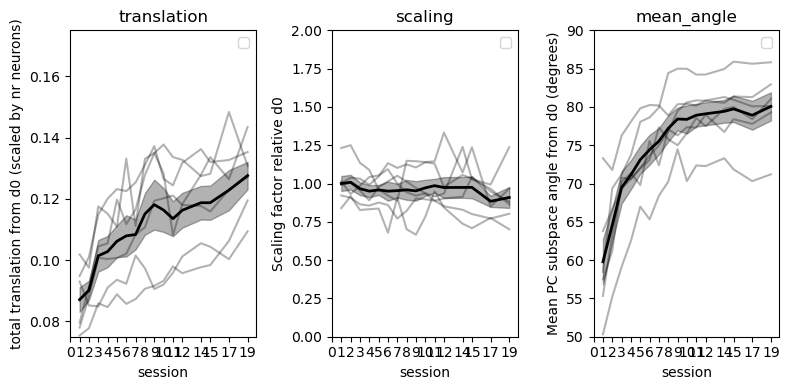

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,time,0.011205,15,0.000747,14.714172,1.207959e-16,0.000393,0.370873,0.160685,False,inf,0.0
1,Error,0.003808,75,0.000051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.084772,15,0.005651,0.638073,0.834129,0.046395,0.211607
1,Error,0.664279,75,0.008857,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,3194.164241,15,212.944283,36.789746,1.980784e-28,0.608949,0.117028
1,Error,434.110670,75,5.788142,NaN,NaN,NaN,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Ole\Documents\script\remapping\remapping\plots.py:546: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


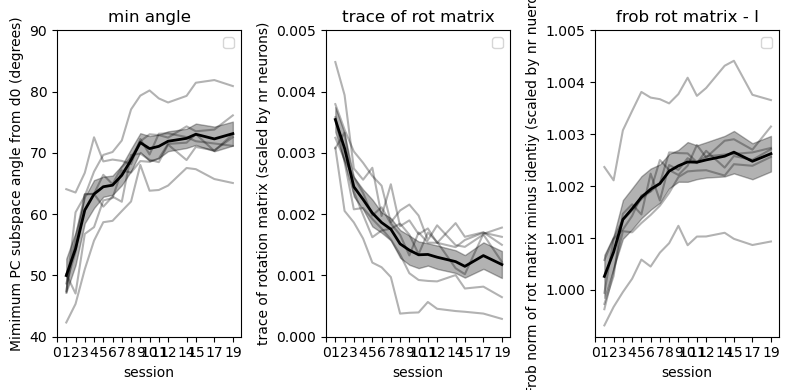

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,4350.700654,15,290.046710,34.305032,1.868621e-27,0.661999,0.118578
1,Error,634.119889,75,8.454932,NaN,NaN,NaN,NaN


c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,time,0.000046,15,3.042683e-06,51.266811,3.520996e-33,1.328103e-07,0.662196,0.183859,False,inf,0.0
1,Error,0.000004,75,5.934995e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\pingouin\distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,time,0.000045,15,3.033288e-06,51.296611,3.452901e-33,1.351657e-07,0.370137,0.183571,False,inf,0.0
1,Error,0.000004,75,5.913233e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
num_animals = len(results['config_1'])
num_days = len(next(iter(results['config_1'].values()))['translation_scale'])

translation_array = np.zeros((num_animals, num_days))
scale_factor_array = np.zeros((num_animals, num_days))
mean_angle_array = np.zeros((num_animals, num_days))
min_angle_array = np.zeros((num_animals, num_days))
princ_angle_array = np.zeros((num_animals, num_days))
trace_angle_array = np.zeros((num_animals, num_days))
frob_angle_array = np.zeros((num_animals, num_days))

for i, animal_data in enumerate(results['config_1'].values()):
    for j, ts in enumerate(animal_data['translation_scale']):
        translation_array[i, j] = ts['translation']
        scale_factor_array[i, j] = ts['scale_factor']
        mean_angle_array[i, j] = ts['mean_angle']
        min_angle_array[i, j] = ts['min_angle']
        princ_angle_array[i, j] = ts['principal_angle']
        trace_angle_array[i, j] = ts['trace']
        frob_angle_array[i, j] = ts['frobenius']

fig, ax = plt.subplots(1,3, figsize=(8, 4))
plots.plot_average_geometry([translation_array], maps,  colors=['k'], ax=ax[0], title='translation', ylim=[0.075, 0.175], labels=[''], ylabel='total translation from d0 (scaled by nr neurons)')
plots.plot_average_geometry([scale_factor_array], maps, colors=['k'],ax= ax[1], title='scaling', ylim=[0,2], labels=[''], ylabel='Scaling factor relative d0')
plots.plot_average_geometry([mean_angle_array],maps, colors=['k'], ax= ax[2], title='mean_angle', ylim=[50,90], labels=[''], ylabel='Mean PC subspace angle from d0 (degrees)')
plt.show()
print_large('Translation')
display(st.repeated_measures_anova_single_condition(translation_array))
print_large('Scaling')
display(st.repeated_measures_anova_single_condition(scale_factor_array))
print_large('rotation ')
display(st.repeated_measures_anova_single_condition(mean_angle_array))


fig, ax = plt.subplots(1,3, figsize=(8, 4))
plots.plot_average_geometry([min_angle_array], maps,  colors=['k'], ax=ax[0], title='min angle', ylim=[40, 90], labels=[''], ylabel='Mimimum PC subspace angle from d0 (degrees)')
plots.plot_average_geometry([trace_angle_array], maps, colors=['k'],ax= ax[1], title='trace of rot matrix', ylim=[0,0.005], labels=[''], ylabel='trace of rotation matrix (scaled by nr neurons)')
plots.plot_average_geometry([frob_angle_array],maps, colors=['k'], ax= ax[2], title='frob rot matrix - I', ylim=[0.9991,1.005], labels=[''], ylabel='Frob norm of rot matrix minus identiy (scaled by nr nuerons)')
plt.show()
print_large('min angle')
display(st.repeated_measures_anova_single_condition(min_angle_array))
print_large('trace of rot matrix')
display(st.repeated_measures_anova_single_condition(trace_angle_array))
print_large('frob rot matrix - I ')
display(st.repeated_measures_anova_single_condition(frob_angle_array))




In [14]:
x1=translation_array
x2=scale_factor_array
x3=mean_angle_array
print(np.shape(all_before_correlations))

(6, 16)


        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y_std  
No. Observations: 96      Method:             REML   
No. Groups:       6       Scale:              0.0155 
Min. group size:  16      Log-Likelihood:     44.9040
Max. group size:  16      Converged:          Yes    
Mean group size:  16.0                               
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept -0.000    0.073  -0.000 1.000 -0.143  0.143
x1_std    -0.178    0.049  -3.644 0.000 -0.274 -0.082
x2_std     0.006    0.021   0.264 0.792 -0.036  0.047
x3_std    -0.846    0.040 -20.926 0.000 -0.925 -0.767
Group Var  0.031    0.224                            



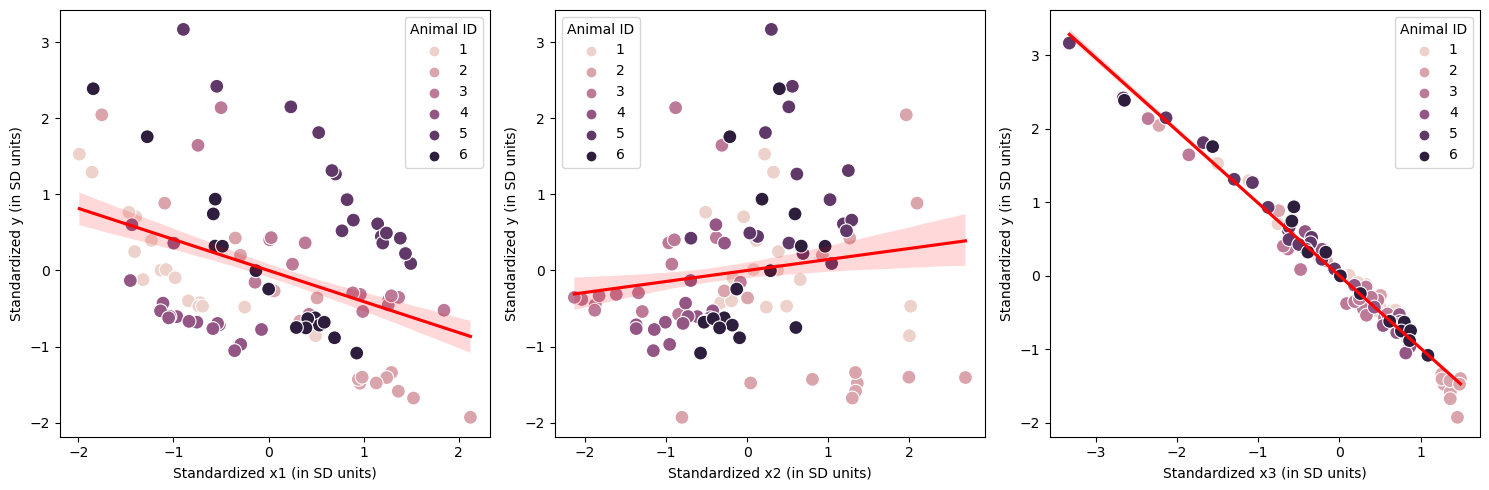

Intercept    1.000000e+00
x1_std       2.685422e-04
x2_std       7.919137e-01
x3_std       3.104857e-97
Group Var    2.659096e-01
dtype: float64


In [15]:
def run_analysis(x1, x2, x3, y, animal_ids, standardize=True):
    data_dict = {
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'y': y,
        'animal_id': animal_ids
    }
    
    results_ml, data, prefix = st.fit_mixed_model(data_dict, standardize=standardize)
    print(results_ml.summary())
    #fig_residuals = plots.plot_partial_residuals(results, data, prefix)
    #plt.figure(fig_residuals.number)
    #plt.show()
    

    fig_scatter = plots.plot_scatter(data, prefix)
    plt.figure(fig_scatter.number)
    plt.show()
    
    return results_ml, data, (_, fig_scatter)

results_ml, data, fig = run_analysis(translation_array, scale_factor_array,  mean_angle_array, all_before_correlations, np.repeat([1, 2, 3, 4, 5,6], 16))
print(results_ml.pvalues)
print_large('x1 = Translation, x2 = Scaling, x3 = Rotation, y = pop vector correlation to d0. All 4 standardized to compare on a common scale. Linear mixed models to account for differences across animals')